# Prediction Titanic Dataset Using Feature Engineering and  Data Preprocessing

# Import Necessary Libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
!pip install missingno
import missingno as msno

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.3f' % x)

# Import Dataset

In [50]:
titanic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/titanic.csv")
df = titanic.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


# General Information About to Dataset

In [51]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [52]:
check_df(df)

######################### Head #########################
   PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 26.000      0      0  STON/O2. 3101282  7.925   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female 35.000      1      0            113803 53.100  C123        S
4            5         0       3                           Allen, Mr. William Henry    male 35.000      0      0            373450  8.050   NaN        S
#########################

# Anaylsis of Categorical and Numerical Variables

In [53]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [54]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_but_cat: {len(num_but_cat)}")

Observations: 891
Variables: 12
Cat_cols: 6
Num_cols: 3
Cat_but_car: 3
Num_but_cat: 4


# Fearure Engineering

In [55]:
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')
df["NEW_NAME_LETTER_COUNT"] = df["Name"].str.len()
df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))
df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
df["NEW_TITLE"] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1
df["NEW_AGE_PCLASS"] = df["Pclass"] * df["Age"]
df.loc[((df["SibSp"] + df["Parch"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SibSp"] + df["Parch"]) == 0), "NEW_IS_ALONE"] = "Yes"
df.loc[(df["Age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 18) & (df["Age"] < 55), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 55), "NEW_AGE_CAT"] = "senior"
df.loc[(df["Sex"] == "male") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["Sex"] == "male") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["Sex"] == "male") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["Sex"] == "female") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["Sex"] == "female") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["Sex"] == "female") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniorfemale"


In [56]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_but_cat: {len(num_but_cat)}")

Observations: 891
Variables: 22
Cat_cols: 14
Num_cols: 5
Cat_but_car: 3
Num_but_cat: 8


# Outlier Analysis

In [57]:
def outlier_threshold(dataframe, col_name, q1=0.05, q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit, up_limit

In [58]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_threshold(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [59]:
def replace_with_thresholds_dataframe(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    replace_with_thresholds(dataframe, col)

In [60]:
replace_with_thresholds_dataframe(df)

# Missing Value Analysis

In [61]:
def missing_value_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [62]:
na_columns = missing_value_table(df, na_name=True)

                n_miss  ratio
Cabin              687 77.100
Age                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
Embarked             2  0.220


In [63]:
remove_cols = ["Name", "Ticket", "Cabin"]
df.drop(remove_cols, axis=1, inplace=True)

In [64]:
na_columns = missing_value_table(df, na_name=True)

                n_miss  ratio
Age                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
Embarked             2  0.220


In [67]:
df["Age"] = df["Age"].fillna(df.groupby("NEW_TITLE")["Age"].transform("median"))

In [68]:
na_columns = missing_value_table(df, na_name=True)

                n_miss  ratio
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
Embarked             2  0.220


In [69]:
df["NEW_AGE_PCLASS"] = df["Pclass"] * df["Age"]
df.loc[((df["SibSp"] + df["Parch"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SibSp"] + df["Parch"]) == 0), "NEW_IS_ALONE"] = "Yes"
df.loc[(df["Age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 18) & (df["Age"] < 55), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 55), "NEW_AGE_CAT"] = "senior"
df.loc[(df["Sex"] == "male") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["Sex"] == "male") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["Sex"] == "male") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["Sex"] == "female") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["Sex"] == "female") & ((df["Age"] > 21) & (df["Age"] < 50)), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["Sex"] == "female") & (df["Age"] >= 50), "NEW_SEX_CAT"] = "seniorfemale"


In [70]:
na_columns = missing_value_table(df, na_name=True)

          n_miss  ratio
Embarked       2  0.220


In [75]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype in ["category", "object"] and len(x.unique())<=10) else x, axis=0)

In [76]:
na_columns = missing_value_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [77]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.000,1,0,7.250,S,0,23.000,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,female,38.000,1,0,71.283,C,1,51.000,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,female,26.000,0,0,7.925,S,0,22.000,3,0,Miss,1,78.000,Yes,mature,maturefemale
3,4,1,1,female,35.000,1,0,53.100,S,1,44.000,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,male,35.000,0,0,8.050,S,0,24.000,4,0,Mr,1,105.000,Yes,mature,maturemale


# Encoding

In [78]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [79]:
def label_encoder_dataframe(dataframe):
  binary_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ["int", "float"] and dataframe[col].nunique() == 2]
  for col in binary_cols:
    label_encoder(dataframe, col)

In [80]:
label_encoder_dataframe(df)

In [81]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.000,1,0,7.250,S,0,23.000,4,0,Mr,2,66.000,0,mature,maturemale
1,2,1,1,0,38.000,1,0,71.283,C,1,51.000,7,0,Mrs,2,38.000,0,mature,maturefemale
2,3,1,3,0,26.000,0,0,7.925,S,0,22.000,3,0,Miss,1,78.000,1,mature,maturefemale
3,4,1,1,0,35.000,1,0,53.100,S,1,44.000,7,0,Mrs,2,35.000,0,mature,maturefemale
4,5,0,3,1,35.000,0,0,8.050,S,0,24.000,4,0,Mr,1,105.000,1,mature,maturemale


In [90]:
def one_hot_encoding(dataframe, drop_first=True):
  label_encoder_dataframe(dataframe)
  cat_cols = [col for col in dataframe.columns if 20 >= dataframe[col].nunique() > 2]
  dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
  return dataframe

In [91]:
df = one_hot_encoding(df)

In [92]:
df.head()

,PassengerId,Survived,Sex,Age,Fare,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale,NEW_TITLE_Col,NEW_TITLE_Countess,NEW_TITLE_Don,NEW_TITLE_Dr,NEW_TITLE_Jonkheer,NEW_TITLE_Lady,NEW_TITLE_Major,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mlle,NEW_TITLE_Mme,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Ms,NEW_TITLE_Rev,NEW_TITLE_Sir
0,1,0,1,22.000,7.250,0,23.000,0,66.000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,1,0,38.000,71.283,1,51.000,0,38.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3,1,0,26.000,7.925,0,22.000,0,78.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,1,0,35.000,53.100,1,44.000,0,35.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,0,1,35.000,8.050,0,24.000,0,105.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Standard Scaler

In [93]:
def robust_scaler(dataframe, num_col):
  temp_df = dataframe.copy()
  rs = RobustScaler()
  temp_df[num_col] = rs.fit_transform(temp_df[[num_col]])
  return temp_df

In [94]:
def robust_scaler_dataframe(dataframe):
  temp_df = dataframe.copy()
  rs = RobustScaler()
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    temp_df[col] = rs.fit_transform(temp_df[[col]])
  return temp_df

In [96]:
df = robust_scaler_dataframe(df)

In [98]:
df.drop("PassengerId", axis=1, inplace=True)

In [99]:
df.head()

,Survived,Sex,Age,Fare,NEW_CABIN_BOOL,NEW_NAME_LETTER_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale,NEW_TITLE_Col,NEW_TITLE_Countess,NEW_TITLE_Don,NEW_TITLE_Dr,NEW_TITLE_Jonkheer,NEW_TITLE_Lady,NEW_TITLE_Major,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mlle,NEW_TITLE_Mme,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Ms,NEW_TITLE_Rev,NEW_TITLE_Sir
0,0,1,-0.571,-0.312,0,-0.200,0,0.080,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,0,0.571,2.461,1,2.600,0,-0.480,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,-0.286,-0.283,0,-0.300,0,0.320,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0.357,1.674,1,1.900,0,-0.540,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0.357,-0.277,0,-0.100,0,0.860,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Create a Base Model without any Feature Engineering

In [113]:
titanic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/titanic.csv")
dff = titanic.copy()
dff.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [114]:
dff.dropna(inplace=True)

In [115]:
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)

In [116]:
y = dff["Survived"]

In [117]:
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [119]:
rf_model = RandomForestClassifier(random_state=20).fit(X_train, y_train)

In [120]:
y_pred = rf_model.predict(X_test)

In [121]:
print("Accuracy: ", accuracy_score(y_pred, y_test))

Accuracy:  0.6909090909090909


# Create a Base Model Using Feature Engineering

In [124]:
def RF_Model_FI(dataframe, target, test_size=0.30, save=False):
  y = dataframe[target]
  X = dataframe.drop(target, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=17)
  rf_model = RandomForestClassifier(random_state=17).fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)

  print(15*"#", "Model Metrics Using Feature Engineering", 15*"#")
  print(f"Acuuracy: {round(accuracy_score(y_pred, y_test), 2)}")
  print(f"Recall: {round(recall_score(y_pred, y_test), 2)}")
  print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
  print(f"ROC_AUC: {round(roc_auc_score(y_pred, y_test), 2)}")
  print(f"F1: {round(f1_score(y_pred, y_test), 2)}")

  feature_imp = pd.DataFrame({'Value': rf_model.feature_importances_, 'Feature': X.columns})
  plt.figure(figsize=(14,14))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
  plt.title("Features")
  plt.tight_layout()
  if save:
    plt.savefig("importance_features.jpg")


############### Model Metrics Using Feature Engineering ###############
Acuuracy: 0.81
Recall: 0.81
Precision: 0.71
ROC_AUC: 0.81
F1: 0.76


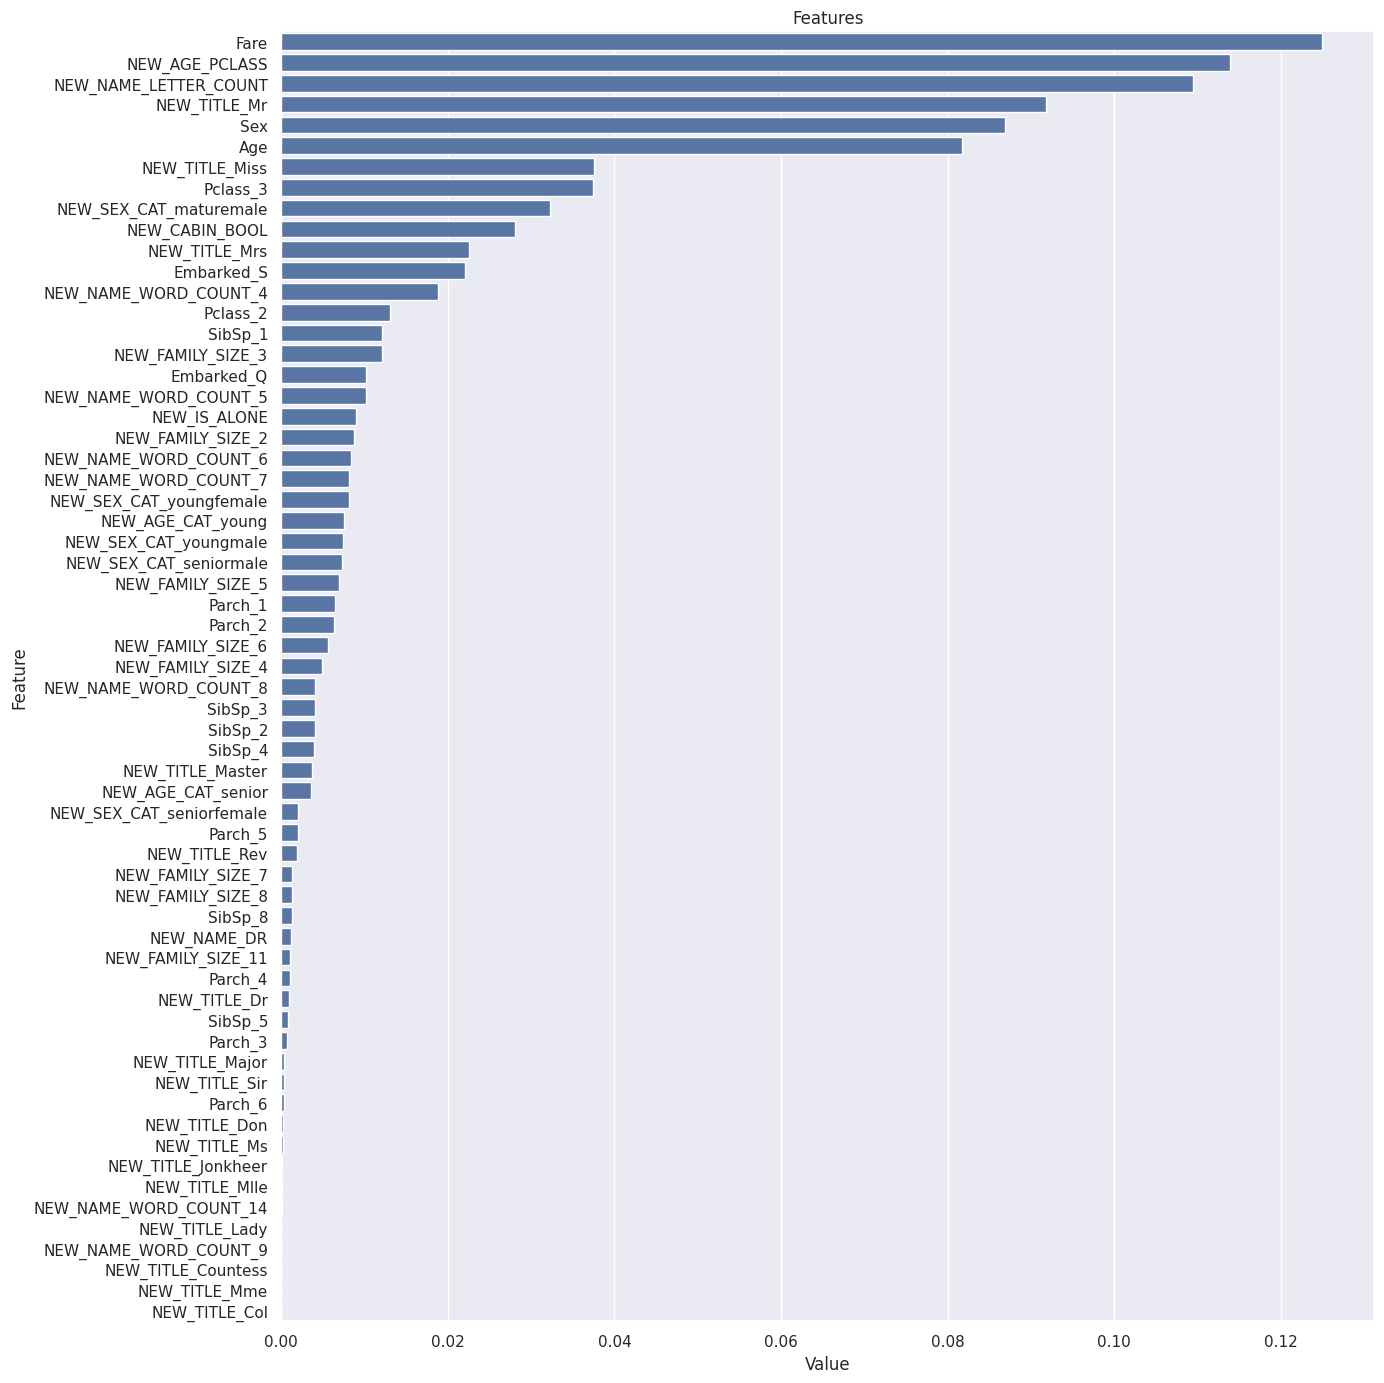

In [125]:
RF_Model_FI(df, "Survived")